In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import distinctipy as dpy
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors as colors
from pyproj import CRS

1. Load data

In [2]:
trajectories_df = pd.read_csv("../data/megamove_v21_timecell_format0.csv")
trajectories_df.head()

,newid,LATITUDE,LONGITUDE,dt_f0,timestay,c05
0,0,-66.666670,140.016670,41230.004861,0.047691,33760
1,0,-66.662651,140.003204,41230.100243,0.057934,33760
2,0,-66.662598,140.003143,41230.120729,0.020556,33760
3,0,-66.662636,140.003204,41230.141354,0.020631,33760
4,0,-66.662605,140.003204,41230.161991,0.020828,33760


In [3]:
metadata_df = pd.read_csv("../data/megamove_v21_metadatamore_taxa.csv")
metadata_df.head()

,NewID,OrigID,Species,Taxa,Tag,Sex,Weight,Length
0,0,20121204-F1-45,Adelie penguin,Penguins,GPS,F,NaN,NaN
1,1,20121205-F1-37,Adelie penguin,Penguins,GPS,F,NaN,NaN
2,2,20121206-F1-49,Adelie penguin,Penguins,GPS,F,NaN,NaN
3,3,20121206-F1-63,Adelie penguin,Penguins,GPS,F,NaN,NaN
4,4,20121207-F1-31,Adelie penguin,Penguins,GPS,F,NaN,NaN


**First step** Normalice the timestay of each individual, so the sum of the timestay of each individual is 30 (removing the indivuals with no timestay)




In [4]:
# Sum the total time of each individual
times_dict = trajectories_df.groupby("newid").timestay.sum().to_dict()
individual_trajectories_times = trajectories_df.groupby("newid").timestay.sum().to_frame().reset_index()
l1 = len(trajectories_df.newid.unique()) 
# remove individuals with total time = 0
nonvalidids = individual_trajectories_times[individual_trajectories_times.timestay == 0].newid.to_numpy()  
bf_species_counts = metadata_df.Species.value_counts()
print("Sizes of speceies before data cleaning")
display(pd.DataFrame(bf_species_counts))


trajectories_df = trajectories_df[ ~(trajectories_df.newid.isin(nonvalidids))]
metadata_df = metadata_df[ ~(metadata_df.NewID.isin(nonvalidids))]
print("Sizes of speceies after data cleaning")
af_species_counts = metadata_df.Species.value_counts().sort_index()
Species2Size = dict(zip(af_species_counts.index, af_species_counts.values))
display(pd.DataFrame(af_species_counts))
l2 = len(trajectories_df.newid.unique()) 
print("Number of individuals removed: ", l1-l2)
# Normalize time
trajectories_df.loc[:, "norm_timestay"] = trajectories_df.apply(lambda x: x.timestay / times_dict[x.newid] if times_dict[x.newid]>0 else 0., axis=1)    
trajectories_df.loc[:, "timestay (1/30days)"] = trajectories_df.loc[:, "norm_timestay"] * 30
newids = trajectories_df.newid.unique()


print("Total normalized time", trajectories_df.loc[:, "timestay (1/30days)"].sum() /30 )
print("Total normalized time", trajectories_df.loc[:, "norm_timestay"].sum())
print("Total indiividuals", len(newids))

Sizes of speceies before data cleaning


,count
Species,
Audouins gull,1229
Corys shearwater,945
Northern gannet,767
Black-browed albatross,544
Little penguin,533
...,...
Broadnose sevengill shark,1
Longfin mako shark,1
Sandbar shark,1


Sizes of speceies after data cleaning


,count
Species,
Adelie penguin,151
Arctic Herring gull,28
Ascension frigatebird,33
Atlantic puffin,20
Audouins gull,1229
...,...
West Indian manatee,9
Western gull,41
Whale shark,257


Number of individuals removed:  162
Total normalized time 12625.999999999998
Total normalized time 12625.999999999993
Total indiividuals 12626


2. EEZ map

Here we load the shapefiles of the EEZ and the continental shelf.

In [5]:
EEZshapefile = gpd.read_file("../data/EEZ shapefile/EEZ_land_v2_201410.shp")
EEZshapefile.drop(["OBJECTID", "Changes", "Shape_Leng", "Shape_Area"], axis=1, inplace=True)
Continets = gpd.read_file("../data/Continents/ref-coastline-2016-60m.shp/COAS_RG_60M_2016_4326.shp/COAS_RG_60M_2016_4326.shp")
# Define the complete world
Continent_geometry = unary_union(Continets.geometry)
EEZshapefile["continental_geometry"] = EEZshapefile.geometry.intersection(Continent_geometry)
EEZshapefile["EEZ_geometry"] = EEZshapefile.geometry
EEZshapefile["marine_geometry"] = EEZshapefile.geometry.difference(EEZshapefile.continental_geometry)
EEZshapefile.drop(columns="geometry", axis=1, inplace=True)
EEZshapefile.set_geometry("marine_geometry", inplace=True)

highseas_points = []

# construct the boundaries of the high seas as a list of points of the square bounding box

for lat in np.arange(-90, 90.5, 0.5):
    highseas_points.append(Point(-180., lat))

for lon in np.arange(-180, 180.5, 0.5):
    highseas_points.append(Point(lon, 90.))

for lat in np.arange(90, -90.5, -0.5):
    highseas_points.append(Point(180., lat))

for lon in np.arange(180, -180.5, -0.5):
    highseas_points.append(Point(lon, -90.))

HighSeasPoly = Polygon(highseas_points) - EEZshapefile.EEZ_geometry.unary_union

#Add the high seas to the EEZ shapefile
EEZshapefile = gpd.GeoDataFrame(
    pd.concat([EEZshapefile, 
               gpd.GeoDataFrame({"ISO_3digit": "-1",
                    "Country": "-1",
                    "continental_geometry": Polygon([]),
                    "EEZ_geometry": HighSeasPoly,
                    "marine_geometry": HighSeasPoly
                    }, index=[0])])).reset_index(drop=True)

EEZshapefile.set_geometry("continental_geometry", inplace=True)



In [6]:
# write a dictionary that maps Country to ISO_3digit and save it as "eez_to_iso3.csv"

eez_to_iso3 = dict(zip(EEZshapefile.Country, EEZshapefile.ISO_3digit))

with open("../data/eez_to_iso3.csv", "w") as f:  
    f.write("Country;ISO_3digit\n")
    for k, v in eez_to_iso3.items():
        f.write(f"{k};{v}\n")

We will use the intersection between the continental shelf and the EEZs to define the continental and oceanic domains of the contries. It could also be possible to search for another dataset with the countries shapefiles, but by doing so we could find some inconsistencies with the EEZ shapefiles, such as the countries names, codes, resolution, definition of conflict zones, threatment of dependant areas, etc.

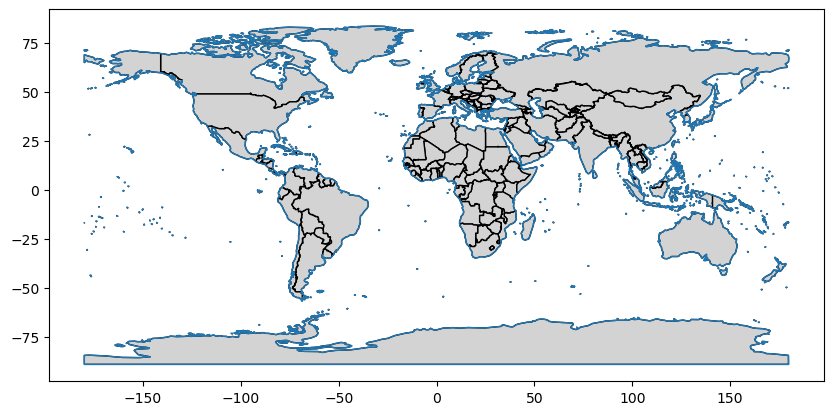

In [7]:

fig, ax = plt.subplots(figsize=(10, 10))
EEZshapefile.plot(color="lightgrey", edgecolor="black", ax=ax)
Continets.plot(color=(0,0,0,0), edgecolor="tab:blue", ax=ax)
plt.show()

# # repeat the plot changing the crs of the EEZshapefile to a equal area projection crs
# fig, ax = plt.subplots(figsize=(10, 10))
# EEZshapefile.to_crs("ESRI:54009").plot(color="lightgrey", edgecolor="black", ax=ax)
# Continets.plot(color=(0,0,0,0), edgecolor="tab:blue", ax=ax)
# plt.show()


3. Load Income data

In [8]:
income = pd.read_excel("../data/CLASS.xlsx", sheet_name="List of economies").iloc[:218]
display(income.sample(5))

,Economy,Code,Region,Income group,Lending category
115,Lithuania,LTU,Europe & Central Asia,High income,NaN
6,Argentina,ARG,Latin America & Caribbean,Upper middle income,IBRD
187,Turks and Caicos Islands,TCA,Latin America & Caribbean,High income,NaN
20,"Bahamas, The",BHS,Latin America & Caribbean,High income,NaN
143,Nicaragua,NIC,Latin America & Caribbean,Lower middle income,IDA


**Income data: 218 entries**

**EEZ data: 261 entries**



I have Economic data of 218 countries according to the **world bank**, and 261 EEZ zones. 7 countries have no EEZ, 15 EEZ Zones are conflict zones between different countries.


- The economies of Macao (MAC) and Hong Kong (HKG) do not have EEZs but are within the EEZ of China (CHN).
- Kosovo (XKX) does not have an EEZ, but is within the EEZ of Serbia (SRB).

In total 210 EEZ map directly to a economy. 
- The EEZ of MNP++ is divided in the economies of MNP and GUM, that are both high income economies. *manualy introduced*
- The EEZs of Guemsey and Jersey both belong to the Channel islands economy, that is high income. *manualy introduced*
- Curacao has two different codes on each dataset. *manualy introduced*
This adds 4 more EEZ to income data, total of 214. 15 EEZs are conflict zones that are not mapped to any economy.

The other 32 EEZs are not mapped to any economy, but are not conflict zones. They are:
- Anguilla (AIA): UK overseas territory
- Netherlands Antilles (ANT): The EEZ contains the island of Sant Eustatius (Politically part of the BES Islands), that is part of the Netherlands (NLD)
- Antartica (ATA): Antartica
- French Southern & Antarctic Lands (ATF): French overseas territory
- Bonaire, Sint Eustatius and Saba (BES): Dutch overseas territory. The EEZ only contains Bonaire and Saba.
- Bouvet Island (BVT): Norwegian overseas territory. Inhabited.
- Cocos (Keeling) Islands (CCK): Australian overseas territory. 
- Cook Islands (COK): New Zealand associated state.
- Clipperton Island (CPT): French overseas territory.       
- Christmas Island (CXR): Australian external territory (non-self-governing).
- Western Sahara (ESH): Sahrawi Arab Democratic Republic territory occupied by morocco.
- Falkland Islands (Malvinas) (FLK): British overseas territory.
- Guadalupe (GLP): French overseas territory.
- French Guiana (GUF): French overseas territory.
- Heard Island and McDonald Islands (HMD): Australian external territory. Inhabited.    
- British Indian Ocean Territory (IOT): British overseas territory. Military base.
- Montserrat (MSR): British overseas territory.
- Martinique (MTQ): French overseas territory.
- Mayotte (MYT): French overseas territory.
- Norfolk Island (NFK): Australian external territory (non-self-governing).
- Niue (NIU): New Zealand associated state.
- Pitcairn (PCN): British overseas territory.
- Reunion (REU): French overseas territory.
- South Georgia and the South Sandwich Islands (SGS): British overseas territory.
- Saint Helena, Ascension and Tristan da Cunha (SHN): British overseas territory.   
- Svalbard (SJM): Norwegian overseas territory.
- Jan Mayen (SJM): Norwegian overseas territory. No permanet populaition.
- Saint Pierre and Miquelon (SPM): French overseas territory.
- Tokelau (TKL): New Zealand dependent territory.
- United States Minor Outlying Islands (UMI): US overseas territory.
- Vatican City (VAT): Vatican City State. No oceanic territory.
- Wallis and Futuna (WLF): French overseas territory.





The economies of Macao (MAC) and Hong Kong (HKG) do not have EEZs but are within the EEZ of China (CHN).
Kosovo (XKX) does not have an EEZ, but is within the EEZ of Serbia (SRB).




In [9]:
# EEZs with no income data
# EEZshapefile.loc[EEZshapefile.ISO_3digit.isin(np.setdiff1d(EEZshapefile.ISO_3digit.unique(), income.Code))].sort_values("ISO_3digit")   

In [10]:
# Income data with no EEZ
# income.loc[income.Code.isin(np.setdiff1d(income.Code.unique(), EEZshapefile.ISO_3digit.unique()))]

In [11]:
intersect = np.intersect1d(income.Code, EEZshapefile.ISO_3digit.unique())
np.setdiff1d(income.Code, EEZshapefile.ISO_3digit.unique()) # Codes that have income but not EEZ
# chanel islands, Curacao, Guam, Hong Kong, Macao, Northern Mariana Islands, Kosovo

# Drop the ones that have no income data, plot in white
NoDataIncome = np.setdiff1d(EEZshapefile.ISO_3digit.unique(), income.Code) # Codes that have EEZ but not income


EEIncomeData = income.loc[income.Code.isin(intersect), ["Code", "Income group"]].rename(columns={"Code": "ISO_3digit"})
income_dict = {'Low income':0., 'Lower middle income':1.,
                'Upper middle income':2., 'High income':3., np.nan:np.nan}

EEZshapefile = pd.merge(EEZshapefile, EEIncomeData, on="ISO_3digit", how="left")
EEZshapefile.loc[:, "Income group"] = EEZshapefile.loc[:, "Income group"].apply(lambda x: income_dict[x])

# introduce by hand some problematic incomes
EEZshapefile.loc[EEZshapefile.loc[:, "ISO_3digit"] == "MNP++", "Income group"] = 3. # Northern Mariana Islands (MNP) + Guam (GUM)
EEZshapefile.loc[EEZshapefile.loc[:, "ISO_3digit"] == "CW", "Income group"] = 3.    # Curacao (code discrepancy)
EEZshapefile.loc[EEZshapefile.loc[:, "ISO_3digit"] == "GGY", "Income group"] = 3.   # Guernsey (belong to channel islands)
EEZshapefile.loc[EEZshapefile.loc[:, "ISO_3digit"] == "JEY", "Income group"] = 3.   # Jersey (belong to channel islands)


In [12]:
# Crear una funcion que me mapee una coordenaa a una celda de 0.5x0.5 grados
# En la que la celada 0 es la de latitud -90 y longitud -180
# La celda 1 es la de latitud -90 y longitud -179.5, etc.

def coor_to_cell(lat, lon, cell_size=0.5):
    """Map a coordinate to a cell of size cell_size x cell_size degrees.
    using the convention that cell 0 is the one with latitud -90 and longitud -180
    and cell 1 is the one with latitud -90 and longitud -179.5, etc.

    coordinates must be in decimal degrees, indicating latitud and longitud of the bottom left corner of the cell.
    """
    if lat < -90 or lat > 90:
        raise ValueError("Latitud debe estar entre -90 y 90")
    elif lon < -180 or lon > 180:
        raise ValueError("Longitud debe estar entre -180 y 180")
    elif 360 % cell_size != 0:
        raise ValueError("El tamaño de celda debe ser un divisor de 360")
    
    cell_per_row = 360 / cell_size
    row = (lat + 90) // 0.5
    col = (lon + 180) // 0.5
    cell = row * cell_per_row + col
    return int(cell)

4. Run Jorge's cell dictionary

In [13]:
cell_to_eez = {}
cell_centroids = {}
with open("../data/cellseez.csv", "r") as f:
    f.readline()
    for l in f:
        line = l.strip().split(",")
        lat, lon = float(line[1]), float(line[2])
        cellID = coor_to_cell(lat-0.25, lon-0.25)
        cell_centroids[cellID] = (lat, lon)
        cell_to_eez[cellID] = l.strip().split('",')[-1].replace('"', "")
cell_to_eez = dict(sorted(cell_to_eez.items()))


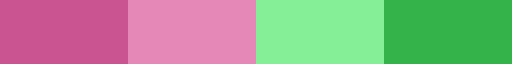

In [14]:
income_colors = [(189/255, 42/255, 118/255, 0.8), (223/255, 105/255, 166/255, 0.8), (103/255, 235/255, 127/255, 0.8), (0, 161/255, 29/255, 0.8)]
income_cmap = dpy.get_colormap(income_colors)
income_cmap

5. Compute the mean time each individual spends in each EEZ

Ahora ya tengo el mapa de celda-> EEZ. Ya tengo computado cuanto tiempo x30dias pasa cada individuo en las celdas que visita.

Tengo que contar las celdas que 

- dividir el tiempo entre el numero de individuos de cada especie
- sumar los tiempos de todos los individuos en cada region
- agregar las celdas a EEZs.

Before saving, I create a dictionary that maps the species and Countries to ints, so they weight less in the file.

In [15]:
all_species = np.sort(bf_species_counts.index.to_numpy())
species_to_int = dict(zip(all_species, np.arange(len(all_species))))

all_eezs = np.sort(EEZshapefile.Country.unique())
eez_to_int = dict(zip(all_eezs, np.arange(len(all_eezs))))

# save the dictionaries as csv
with open("../data/species_to_int.csv", "w") as f:
    f.write("Species;Int\n")
    for k, v in species_to_int.items():
        f.write(f"{k};{v}\n")

with open("../data/eez_to_int.csv", "w") as f:  
    f.write("EEZ;Int\n")
    for k, v in eez_to_int.items():
        f.write(f"{k};{v}\n")



In [16]:
id_to_species = dict(zip(metadata_df.NewID, metadata_df.Species))
trajectories_df.loc[:, "Species"] = trajectories_df.newid.apply(lambda x: id_to_species[x])
trajectories_df.loc[:, "EEZ"] = trajectories_df.c05.apply(lambda x: cell_to_eez[x])
SpeciesSize = metadata_df.Species.value_counts().to_dict()
display(trajectories_df.sample(5))


,newid,LATITUDE,LONGITUDE,dt_f0,timestay,c05,norm_timestay,timestay (1/30days),Species,EEZ
1132771,4996,-21.41800,164.99900,41549.758264,0.010116,99329,0.000958,0.028747,Dugong,New Caledonia
5288170,10125,60.39500,-146.76500,40336.209028,0.003819,216066,0.000012,0.000359,Salmon shark,United States
888425,4362,39.41782,-9.47125,40278.762743,0.003351,186101,0.006438,0.193146,Corys shearwater,Portugal
5918600,11224,-65.65400,92.70300,39901.169167,0.220694,35105,0.002007,0.060202,Southern elephant seal,Antarctica
4181155,8044,-53.16300,73.63600,37980.948148,0.034913,53067,0.001565,0.046963,Macaroni penguin,Heard I. & McDonald Is.


Make a copy of the dataframe that contains all the relevant information, including the normalized timestay, the especie, the EEZ and its income...


In [17]:

trajectories_save = trajectories_df.copy()
trajectories_save.loc[:, "Species"] = trajectories_save.Species.apply(lambda x: species_to_int[x])
trajectories_save.loc[:, "EEZ"] = trajectories_save.EEZ.apply(lambda x: eez_to_int[x])
# uncoment to save the data if needed
# trajectories_save.to_csv("../data/full_data_inds.csv.gz", index=False, sep=";")

Calculamos la media de tiempo que pasa cada especie en cada EEZ. Calculamos tambien la varianza, la desviacion estandar y el error estandar de la media.

Para ello debemos **agregar todos los puntos de cada indiividuo en las mismas EEZ**. Este era el error. Cuando sumo los cuadrados sin agregar los puntos en la misma EEZ de cada individuo, en lugar de sumar N terminos, siendo N el numero de indiividuos de la especie, sumo R, siendo R el número de registros, que es mucho mayor que N. en la media no hay diferencia por que es lineal, pero en la varianza si, por que es cuadratica.

In [18]:

agg_trajectories = trajectories_df.groupby(["newid", "Species", "EEZ"]).sum().loc[:, "timestay (1/30days)"].reset_index()

# Add the square of the time 
agg_trajectories.loc[:, "timestay^2 (1/30days)"] = agg_trajectories.loc[:, "timestay (1/30days)"]**2

# Compute the mean using the species size
SpeciesEEZTimes = pd.DataFrame(agg_trajectories.groupby(["EEZ", "Species"], ).sum().loc[:, ["timestay (1/30days)", "timestay^2 (1/30days)"]]).rename(columns={"timestay (1/30days)": "sum timestay (1/30days)", "timestay^2 (1/30days)": "sum timestay^2 (1/30days)"}).reset_index()
SpeciesEEZTimes.loc[:, "mean timestay (1/30days)"] = SpeciesEEZTimes["sum timestay (1/30days)"] / SpeciesEEZTimes.Species.apply(lambda x: Species2Size[x])
SpeciesEEZTimes.loc[:, "mean timestay^2 (1/30days)"] = SpeciesEEZTimes["sum timestay^2 (1/30days)"] / SpeciesEEZTimes.Species.apply(lambda x: Species2Size[x])

# Compute the variance using the mean
SpeciesEEZTimes.loc[:, "variance timestay (1/30days)"] = SpeciesEEZTimes.apply(lambda x: x["mean timestay^2 (1/30days)"] - x["mean timestay (1/30days)"]**2, axis=1)
# Correct the variance if it is negative due to numerical errors
SpeciesEEZTimes.loc[SpeciesEEZTimes.loc[:, "variance timestay (1/30days)"] < 0, "variance timestay (1/30days)"] = 0.

# Compute the standard deviation using the variance
SpeciesEEZTimes.loc[:, "std timestay (1/30days)"] = SpeciesEEZTimes.loc[:, "variance timestay (1/30days)"].apply(lambda x: np.sqrt(x))

# Compute the standard error using the standard deviation
SpeciesEEZTimes.loc[:, "err. timestay (1/30days)"] = SpeciesEEZTimes.apply(lambda x: x["std timestay (1/30days)"] / np.sqrt(Species2Size[x.Species]), axis=1)

display(agg_trajectories)
agg_trajectories.Species = agg_trajectories.Species.apply(lambda x: species_to_int[x])
agg_trajectories.EEZ = agg_trajectories.EEZ.apply(lambda x: eez_to_int[x])
agg_trajectories = agg_trajectories.sort_values(["newid", "EEZ"]).reset_index(drop=True)
display(agg_trajectories)
agg_trajectories.to_csv("../data/agg_data.csv", index=False, sep=",")
display(SpeciesEEZTimes)




,newid,Species,EEZ,timestay (1/30days),timestay^2 (1/30days)
0,0,Adelie penguin,Antarctica,30.000000,900.000000
1,1,Adelie penguin,Antarctica,30.000000,900.000000
2,2,Adelie penguin,Antarctica,30.000000,900.000000
3,3,Adelie penguin,Antarctica,30.000000,900.000000
4,4,Adelie penguin,Antarctica,30.000000,900.000000
...,...,...,...,...,...
22784,12787,White-tailed tropic bird,Maldives,1.502173,2.256524
22785,12787,White-tailed tropic bird,Mauritius,0.477632,0.228132
22786,12787,White-tailed tropic bird,Oman,0.410633,0.168619
22787,12787,White-tailed tropic bird,Seychelles,10.525889,110.794334


,newid,Species,EEZ,timestay (1/30days),timestay^2 (1/30days)
0,0,0,8,30.000000,900.000000
1,1,0,8,30.000000,900.000000
2,2,0,8,30.000000,900.000000
3,3,0,8,30.000000,900.000000
4,4,0,8,30.000000,900.000000
...,...,...,...,...,...
22784,12787,110,141,1.502173,2.256524
22785,12787,110,147,0.477632,0.228132
22786,12787,110,174,0.410633,0.168619
22787,12787,110,202,10.525889,110.794334


,EEZ,Species,sum timestay (1/30days),sum timestay^2 (1/30days),mean timestay (1/30days),mean timestay^2 (1/30days),variance timestay (1/30days),std timestay (1/30days),err. timestay (1/30days)
0,-1,Arctic Herring gull,37.833639,193.523300,1.351201,6.911546,5.085801,2.255172,0.426187
1,-1,Ascension frigatebird,90.586023,1029.074752,2.745031,31.184083,23.648888,4.863012,0.846542
2,-1,Atlantic puffin,298.290578,5357.535093,14.914529,267.876755,45.433583,6.740444,1.507209
3,-1,Baraus petrel,1275.070513,31301.914470,23.183100,569.125718,31.669581,5.627573,0.758822
4,-1,Black-browed albatross,2603.452224,45830.909469,4.794571,84.403148,61.415234,7.836787,0.336309
...,...,...,...,...,...,...,...,...,...
1096,Yemen,Sooty tern,5.124250,5.114788,0.094894,0.094718,0.085714,0.292769,0.039841
1097,Yemen,Trindade petrel,1.301791,0.365242,0.011320,0.003176,0.003048,0.055208,0.005148
1098,Yemen,Wedge-tailed shearwater,2.855017,1.854505,0.057100,0.037090,0.033830,0.183928,0.026011
1099,Yemen,Whale shark,27.956188,584.019686,0.108779,2.272450,2.260617,1.503535,0.093788


Compute the Rich-Poor presence matrix for the EEZs. This matrix has four quadrants:
- Rich-Rich: number of times a trajectory that starts in a high income country passes through a high income EEZ.
- Rich-Poor: number of times a trajectory that starts in a high income country passes through a low income EEZ.
- Poor-Rich: number of times a trajectory that starts in a low income country passes through a high income EEZ.
- Poor-Poor: number of times a trajectory that starts in a low income country passes through a low income EEZ.

In [19]:
RP_matrix = np.zeros((2,2))
Only_one_visit = np.zeros((2,2))

unique_code_income = EEZshapefile.loc[:, ["ISO_3digit", "Income group"]].value_counts().reset_index().drop(columns="count")
richs = unique_code_income.loc[unique_code_income["Income group"] == 3, "ISO_3digit"].to_numpy()

first_time_id_EEZ = trajectories_df.groupby(["newid", "EEZ"]).agg("min").reset_index().loc[:, ["newid", "EEZ", "dt_f0"]]
first_time_id_EEZ.EEZ = first_time_id_EEZ.EEZ.apply(lambda x: eez_to_iso3[x])
first_time_id_EEZ["Rich"] = first_time_id_EEZ.EEZ.apply(lambda x: x in richs)



In [20]:

start_in_rich = 0
for newid in first_time_id_EEZ.newid.unique():
    id_traj = first_time_id_EEZ.loc[first_time_id_EEZ.newid == newid]
    # find the row with lower dt_f0
    cc = 0 if id_traj.loc[id_traj.dt_f0.idxmin()].Rich else 1
    # find the number of times it visited a rich EEZ
    rich_visted = id_traj.Rich.sum()
    total_visted = len(id_traj)
    RP_matrix[cc, 0] += rich_visted #/ total_visted
    RP_matrix[cc, 1] += (total_visted - rich_visted) #/ total_visted
    if total_visted == 1:
        Only_one_visit[cc, 0] += rich_visted
        Only_one_visit[cc, 1] += (total_visted - rich_visted)
    start_in_rich += cc

print("{} of {} trajectories start in a rich EEZ".format(start_in_rich, len(first_time_id_EEZ.newid.unique())))

4230 of 12626 trajectories start in a rich EEZ


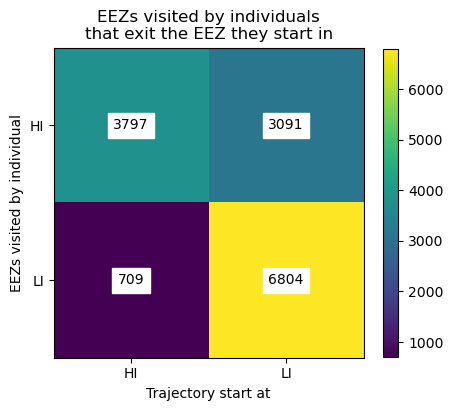

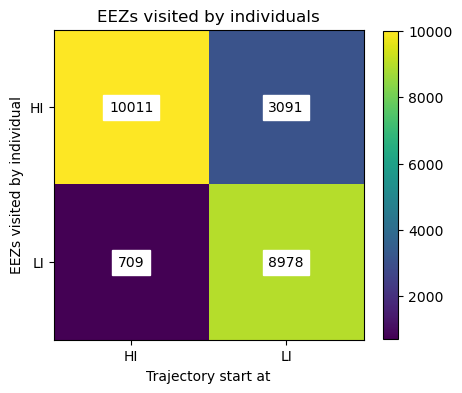

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(RP_matrix - Only_one_visit, cmap="viridis")
ax.set_title(
    "EEZs visited by individuals\nthat exit the EEZ they start in")
# plot colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
# cbar.set_label("Number of trajectories")
# We want to show all ticks...
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
# ... and label them with the respective list entries
ax.set_xlabel("Trajectory start at")
ax.set_ylabel("EEZs visited by individual")
ax.set_xticklabels(["HI", "LI"])
ax.set_yticklabels(["HI", "LI"])
# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(
            j,
            i,
            int(RP_matrix[i, j] - Only_one_visit[i, j]),
            ha="center",
            va="center",
            color="k",
            backgroundcolor="w")    

fig.savefig("../Map/RP_matrix_no_one_visit.png",
            dpi=300,
            bbox_inches="tight")
fig.savefig("../Map/RP_matrix_no_one_visit.pdf",
            dpi=300,
            bbox_inches="tight")

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(RP_matrix, cmap="viridis")
ax.set_title("EEZs visited by individuals")
# plot colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
# cbar.set_label("Number of trajectories")
# We want to show all ticks...
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
# ... and label them with the respective list entries
ax.set_xlabel("Trajectory start at")
ax.set_ylabel("EEZs visited by individual")
ax.set_xticklabels(["HI", "LI"])
ax.set_yticklabels(["HI", "LI"])
# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(
            j,
            i,
            int(RP_matrix[i, j]),
            ha="center",
            va="center",
            color="k",
            backgroundcolor="w")    

fig.savefig("../Map/RP_matrix.png",
            dpi=300,
            bbox_inches="tight")
fig.savefig("../Map/RP_matrix.pdf",
            dpi=300,
            bbox_inches="tight")




The last dataframe is used to create two new ones:
- EEZSpecies: computes the number of species observed in each EEZ
- EEZSizes: Computes the total mean timestay of the individuals at each EEZ

In [22]:
trajectories_df

,newid,LATITUDE,LONGITUDE,dt_f0,timestay,c05,norm_timestay,timestay (1/30days),Species,EEZ
0,0,-66.666670,140.016670,41230.004861,0.047691,33760,0.003168,0.095028,Adelie penguin,Antarctica
1,0,-66.662651,140.003204,41230.100243,0.057934,33760,0.003848,0.115438,Adelie penguin,Antarctica
2,0,-66.662598,140.003143,41230.120729,0.020556,33760,0.001365,0.040959,Adelie penguin,Antarctica
3,0,-66.662636,140.003204,41230.141354,0.020631,33760,0.001370,0.041108,Adelie penguin,Antarctica
4,0,-66.662605,140.003204,41230.161991,0.020828,33760,0.001383,0.041500,Adelie penguin,Antarctica
...,...,...,...,...,...,...,...,...,...,...
6854435,12787,-3.001852,55.677597,40539.013194,0.999306,125031,0.004552,0.136561,White-tailed tropic bird,Seychelles
6854436,12787,0.454047,52.550244,40540.022222,0.753819,130065,0.003434,0.103014,White-tailed tropic bird,-1
6854437,12787,1.173344,53.110498,40540.520833,0.497569,131506,0.002267,0.067996,White-tailed tropic bird,-1
6854438,12787,-2.466126,54.420246,40541.017361,0.248264,126468,0.001131,0.033927,White-tailed tropic bird,Seychelles


In [23]:
EEZSpecies = SpeciesEEZTimes.loc[:, "EEZ"].value_counts().reset_index().rename(columns={"EEZ": "Country", "count": "#Species"})
EEZSpecies.sort_values("Country", inplace=True)
display(EEZSpecies)

EEZSizes = SpeciesEEZTimes.groupby("EEZ").sum().loc[:, ["mean timestay (1/30days)", "err. timestay (1/30days)"]].reset_index().rename(columns={"EEZ": "Country"})
display(EEZSizes)

,Country,#Species
0,-1,67
171,Albania,1
131,Algeria,2
155,American Samoa,1
73,Angola,5
...,...,...
70,Venezuela,5
98,Vietnam,3
44,"Virgin Islands, British",8
37,Western Sahara,9


,Country,mean timestay (1/30days),err. timestay (1/30days)
0,-1,458.646594,56.119577
1,Albania,0.124062,0.078885
2,Algeria,1.493052,0.368493
3,American Samoa,0.969582,0.367002
4,Angola,0.594804,0.309437
...,...,...,...
174,Venezuela,2.373962,1.695778
175,Vietnam,0.096888,0.096659
176,"Virgin Islands, British",1.235713,0.618683
177,Western Sahara,1.053408,0.544897


Y si simplemente añado Highseas a EEZshapefile?

In [24]:

# add the #of species and mean time stay to the EEZCounGeo
EEZshapefile = pd.merge(EEZshapefile, EEZSpecies, on="Country", how="left")
EEZshapefile = pd.merge(EEZshapefile, EEZSizes, on="Country", how="left")

EEZshapefile.loc[:, "mean timestay (1/30days) / species"] = EEZshapefile.loc[:, "mean timestay (1/30days)"] / EEZshapefile.loc[:, "#Species"]
EEZshapefile



,ISO_3digit,Country,continental_geometry,EEZ_geometry,marine_geometry,Income group,#Species,mean timestay (1/30days),err. timestay (1/30days),mean timestay (1/30days) / species
0,-,Conflict zone Japan/Russia,"MULTIPOLYGON (((145.56500 43.99100, 145.63900 ...","POLYGON ((149.156571113 45.49545062500005, 149...","POLYGON ((149.156571113 45.49545062500005, 149...",NaN,3.0,0.068934,0.038081,0.022978
1,-,Conflict zone Japan/South Korea,POLYGON EMPTY,"POLYGON ((134.2216315950001 39.87854129500005,...","POLYGON ((134.2216315950001 39.87854129500005,...",NaN,NaN,NaN,NaN,NaN
2,-,Joint regime Japan/Korea,POLYGON EMPTY,"POLYGON ((126.2457067390001 30.13313987000004,...","POLYGON ((126.2457067390001 30.13313987000004,...",NaN,1.0,0.014620,0.014426,0.014620
3,-,Conflict zone China/Japan/Taiwan,"POLYGON ((123.54600 25.88900, 123.68100 25.711...","POLYGON ((122.900096165 25.22987522200003, 122...","POLYGON ((122.900096165 25.22987522200003, 122...",NaN,NaN,NaN,NaN,NaN
4,-,Spratly Islands,"POLYGON ((114.28500 11.23300, 114.48200 11.009...","POLYGON ((112.2398926440001 13.24706771000007,...","POLYGON ((112.2398926440001 13.24706771000007,...",NaN,2.0,0.049715,0.035857,0.024858
...,...,...,...,...,...,...,...,...,...,...
257,SSD,South Sudan,"POLYGON ((34.09138 9.48753, 34.09416 9.45472, ...","POLYGON ((34.09138136600006 9.487534912000058,...",POLYGON EMPTY,0.0,NaN,NaN,NaN,NaN
258,VTC,Vatican City,"POLYGON ((12.45669 41.90139, 12.45014 41.90089...","POLYGON ((12.45669125900002 41.90139120600003,...",POLYGON EMPTY,NaN,NaN,NaN,NaN,NaN
259,ITA,Italy,"MULTIPOLYGON (((12.13302 47.01256, 12.13611 46...","POLYGON ((12.13301820000004 47.01256413000004,...",MULTIPOLYGON (((13.80221823100004 45.586391179...,3.0,4.0,0.656769,0.291354,0.164192
260,KIR,Kiribati,"MULTIPOLYGON (((-159.39900 4.06500, -159.10400...","POLYGON ((-159.374622539 7.917728175000036, -1...","POLYGON ((-159.374622539 7.917728175000036, -1...",1.0,2.0,0.075248,0.063740,0.037624


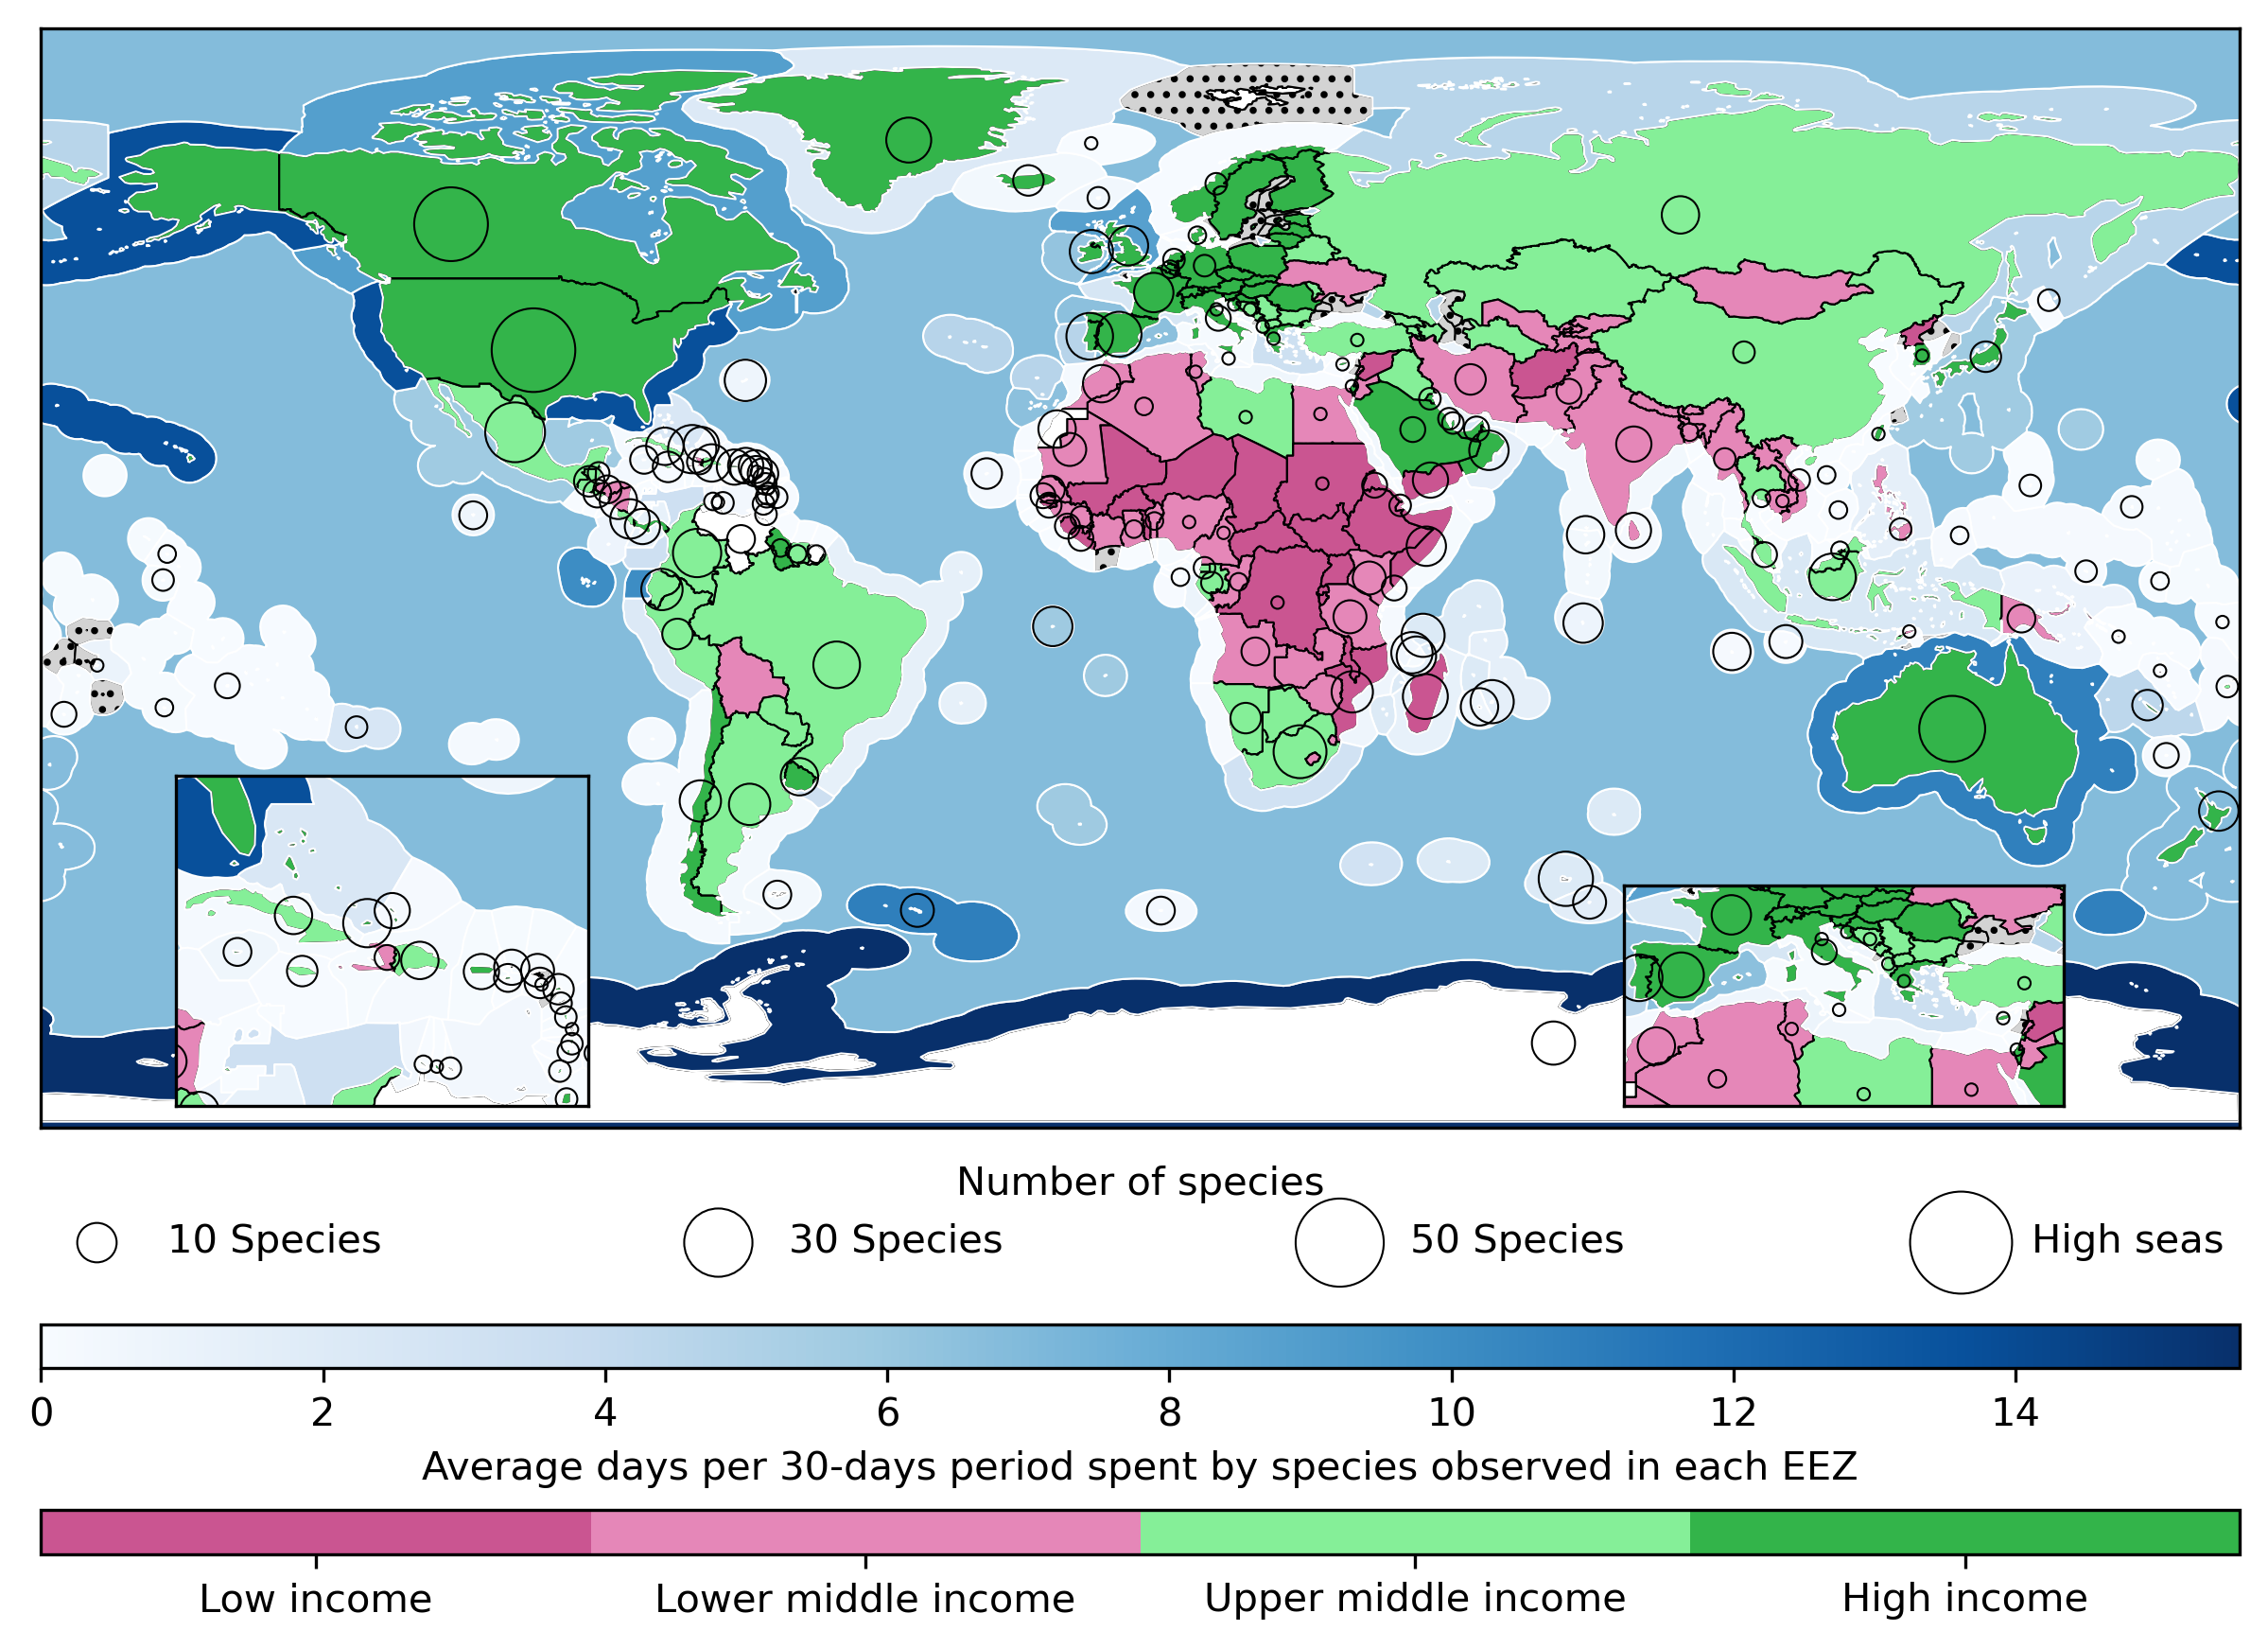

In [25]:

fig, axs = plt.subplots(figsize=(10, 10), dpi = 300)
axs.set_ylim(-90, 90)
axs.set_xlim(-180, 180)
axs.set_xticks([])
axs.set_yticks([])

# Caribbean inset
axcab = axs.inset_axes([0.005, 0.02, 0.3, 0.3])
axcab.set_xlim(-85, -60)
axcab.set_ylim(10, 30)
axcab.set_xticks([])
axcab.set_yticks([])

# Mediterranean inset
axmed = axs.inset_axes([0.72, 0.02, 0.2, 0.2])
axmed.set_xlim(-10, 40)
axmed.set_ylim(25, 50)
axmed.set_xticks([])
axmed.set_yticks([])

plot_scale = 10
vmax =EEZshapefile.loc[:, "mean timestay (1/30days) / species"].max()

for ax in [axs, axcab, axmed]:
    """ Income plots"""
    EEZshapefile.set_geometry("continental_geometry", inplace=True)

    # Plot the country incomes from the EEZ we have data
    EEZshapefile.loc[~EEZshapefile.loc[:, "Income group"].isna()].plot(column="Income group", edgecolor="black", cmap=income_cmap, ax=ax, linewidth=0.5, legend=False)
    # create the colorbar

    # Plot the countries that we don't have income data
    EEZshapefile.loc[EEZshapefile.loc[:, "Income group"].isna()].plot(color="white", edgecolor="black", ax=ax, linewidth=0.5)
    # Plot the conflict zones
    EEZshapefile.loc[EEZshapefile.loc[:, "ISO_3digit"].isin(["-"])].plot(color="white", edgecolor="black", ax=ax, linewidth=0.5)

    """Continental shelf plot"""
    Continets.plot(color=(0,0,0,0), edgecolor="black", ax=ax, linewidth=0.5)


    """Movility data plots"""
    # MISSING plot the EEZ with no data in grey
    EEZshapefile.set_geometry("marine_geometry", inplace=True)
    EEZshapefile.loc[EEZshapefile.loc[:, "mean timestay (1/30days)"].isna()].plot(color="lightgrey", edgecolor="black", ax=ax, linewidth=0.5, hatch="...", alpha=1)



    EEZshapefile.plot(column="mean timestay (1/30days) / species",
                        cmap="Blues", 
                        vmin=0., vmax=vmax, 
                        # legend=True, legend_kwds={"label": "mean days/month spent by species saw in the EEZ", "orientation": "horizontal"},
                        edgecolor="white", linewidth=0.5,
                        ax=ax)      

    ax.scatter(EEZshapefile["continental_geometry"].representative_point().x[:-1],
            EEZshapefile["continental_geometry"].representative_point().y[:-1],
            color=(0,0,0,0), 
            s=EEZshapefile.iloc[:-1].loc[:, "#Species"].to_numpy() * plot_scale, 
            edgecolor="black",
            linewidths=0.5)   


norm = colors.Normalize(vmin=0., vmax=3.)
incomecbar = plt.cm.ScalarMappable(norm=norm, cmap=income_cmap)
ax_cbar = fig.colorbar(incomecbar,
                    ax=axs,
                    orientation="horizontal",
                    pad = -0.05,
                    aspect = 50)
ax_cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
ax_cbar.set_ticklabels(["Low income", "Lower middle income", "Upper middle income", "High income"])



norm = colors.Normalize(vmin=0., vmax=vmax)
timecbar = plt.cm.ScalarMappable(norm=norm, cmap="Blues")
ax_cbar = fig.colorbar(timecbar, 
                    ax=axs, 
                    orientation="horizontal", 
                    pad = 0.1, 
                    aspect = 50,
                    label="Average days per 30-days period spent by species observed in each EEZ")



axs.scatter([], [], color=(0,0,0,0), s=10 * plot_scale, edgecolor="black", linewidths=0.5, label="10 Species")     
axs.scatter([], [], color=(0,0,0,0), s=30 * plot_scale, edgecolor="black", linewidths=0.5, label="30 Species")
axs.scatter([], [], color=(0,0,0,0), s=50 * plot_scale, edgecolor="black", linewidths=0.5, label="50 Species")
axs.scatter([], [], color=(0,0,0,0), s=EEZshapefile.loc[:, "#Species"].iloc[-1] * plot_scale, edgecolor="black", linewidths=0.5, label="High seas")
axs.legend(frameon=False, ncols=4, bbox_to_anchor=(0.0, -0.0, 1., -0.02), mode="expand", borderaxespad=0., title="Number of species")    




plt.show()


fig.savefig("EEZTimeStays.png", dpi=300, bbox_inches="tight")
fig.savefig("EEZTimeStays.pdf", dpi=300, bbox_inches="tight")



In [26]:
EEZshapefile_to_save = EEZshapefile.set_geometry("EEZ_geometry").drop(columns=["continental_geometry", "marine_geometry"], axis=1)
EEZshapefile_to_save.rename(
    columns={"Income group": "Income",
             "mean timestay (1/30days)": "1/30d", 
             "err. timestay (1/30days)": "err_1/30d",
             "mean timestay (1/30days) / species": "1/30d_sp",
             "EEZ_geometry": "geometry"
            },
            inplace=True
)

EEZshapefile_to_save.set_geometry("geometry", inplace=True)
EEZshapefile_to_save.to_file("../data/EEZ shapefile/EEZ_my_data.shp", driver="ESRI Shapefile")

In [27]:
gpd.read_file("../data/EEZ shapefile/EEZ_my_data.shp")

,ISO_3digit,Country,Income,#Species,1/30d,err_1/30d,1/30d_sp,geometry
0,-,Conflict zone Japan/Russia,NaN,3.0,0.068934,0.038081,0.022978,"POLYGON ((149.15657 45.49545, 149.15924 45.486..."
1,-,Conflict zone Japan/South Korea,NaN,NaN,NaN,NaN,NaN,"POLYGON ((134.22163 39.87854, 134.23452 39.539..."
2,-,Joint regime Japan/Korea,NaN,1.0,0.014620,0.014426,0.014620,"POLYGON ((126.24571 30.13314, 126.09167 30.303..."
3,-,Conflict zone China/Japan/Taiwan,NaN,NaN,NaN,NaN,NaN,"POLYGON ((122.90010 25.22988, 122.89410 25.255..."
4,-,Spratly Islands,NaN,2.0,0.049715,0.035857,0.024858,"POLYGON ((112.23989 13.24707, 112.31403 13.297..."
...,...,...,...,...,...,...,...,...
257,SSD,South Sudan,0,NaN,NaN,NaN,NaN,"POLYGON ((34.09138 9.48753, 34.09416 9.45472, ..."
258,VTC,Vatican City,NaN,NaN,NaN,NaN,NaN,"POLYGON ((12.45669 41.90139, 12.45014 41.90089..."
259,ITA,Italy,3,4.0,0.656769,0.291354,0.164192,"POLYGON ((12.13302 47.01256, 12.13611 46.96695..."
260,KIR,Kiribati,1,2.0,0.075248,0.063740,0.037624,"POLYGON ((-159.37462 7.91773, -159.37462 7.917..."
